---
# Análise de Sentimentos MINFRA - Dez/2021
---
**Participantes**


*   José Renato Borelli (Instituto Federal de São Paulo)
*   Liliane Vieira Lopes (Instituto Brasileiro de Museus)
*   Marcela Gomes Corrêa (Ministério da Infraestrutura)
*   Priscilla Amorim dos Santos Rodrigues (Câmara dos Deputados)



## Introdução

### **Descrição do projeto de machine learning**
  
  
**1- Descrição do problema ou tarefa:**  
O Ministério da Infraestrutura tem como visão tornar o Brasil líder em infraestrutura de transportes na América Latina e para isso é preciso “mensurar” o quão perto isso está de acontecer. Uma das formas de se fazer isso, seria utilizar os dados do Twitter analisando o que os cidadãos têm falado sobre as rodovias brasileiras, por exemplo. Mas analisar esses dados de maneira manual e classificar os tweets em positivos e negativos é uma tarefa complexa e passível de erro humano ou subjetividade.

  
**2- Descrição da solução de IA:**  
Por meio do processamento da linguagem natural (NLP), realizar uma Análise de Sentimento de tweets de cidadãos com menção à conta do ministro da infraestrutura, para analisar se são positivos, negativos ou questionamentos.

  
**3- Fonte de dados:**  

1.   Tweets coletados e classificados manualmente pela área de negócio do MINFRA
2.   Base do Kaggle com tweets já classificados ([Link para a base](https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis)) para aumento do número da classe 'negativo'
3.   Tweets coletados e classificados manualmente por nós para aumento do número da classe 'questionamento'


  
**4- Variáveis independentes (preditoras ou "features"):** Texto dos tweets
  
**5- Variável dependente (resposta ou "target"):** Sentimento (positivo, negativo ou questionamento)


**Data:  Dezembro/2021**

## Apêndice



### Bibliotecas

In [1]:
import re
import html
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install plotly==4.12.0

In [3]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
#Instalação do Portugues no Spacy. Esse processo demora mesmo!
#!pip3 install https://github.com/explosion/spacy-models/releases/download/pt_core_news_lg-3.2.0/pt_core_news_lg-3.2.0.tar.gz #pt_core_news_sm

!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2 MB 67.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [5]:
import spacy
import unicodedata
from wordcloud import WordCloud

In [6]:
#NLP
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize

In [7]:
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
url = 'gdrive/My Drive/Bootcamp_ENAP/projeto_final/dados'

In [10]:
#models
import xgboost as xgb

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV 
#tratamento
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    RepeatedStratifiedKFold
) 

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
    TfidfTransformer
)

#métricas
from sklearn.metrics import (
    auc,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
) 


In [11]:
#Instala a Biblioteca eli5
!pip install eli5

In [ ]:
# Importa biblioteca eli5 
import eli5

In [12]:
DEFAULT_RANDOM_STATE = 42

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Funções

#### Tratamento

**_apply_lower**

In [14]:
def _apply_lower(txt):
    return txt.lower()

**_remove_number (txt)**

In [15]:
def _remove_number(txt):
    return re.sub(r'\d+. ', '', txt)

**_remove_url (txt)**

In [16]:
def _remove_url(txt):
    words = ''
    regexp1 = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    regexp2 = re.compile('www?.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    

    urls = regexp1.findall(txt)

    for u in urls:
        txt = txt.replace(u, ' ')

    urls = regexp2.findall(txt)

    for u in urls:
        txt = txt.replace(u, ' ')
        
    return txt

**_remove_regex(txt, regex_pattern)**

In [17]:
def _remove_regex(txt, regex_pattern):
    matches = re.finditer(regex_pattern, txt)    
    for m in matches: 
        txt = re.sub(m.group().strip(), '', txt)

    return txt

**_remove_accent(txt)**

In [18]:
def _remove_accent(txt):
    return unicodedata.normalize('NFD', txt).encode('ascii', errors='ignore').decode('utf-8')

**_replace_emoticons(data, emoticons = emoticon_list)**

In [19]:
emoticon_list = {
    ':))': 'positive_emoticon',
    ':)': 'positive_emoticon',
    ':D': 'positive_emoticon',
    ':-)': 'positive_emoticon',
    ':-D': 'positive_emoticon',

    ':(': 'negative_emoticon',
    ':-(': 'negative_emoticon',
    ':((': 'negative_emoticon',
    ':-((': 'negative_emoticon',
    ';(': 'negative_emoticon',
    ';-(': 'negative_emoticon',

    '8)': 'neutral_emoticon'
}

In [20]:
def _replace_emoticons(txt, emoticons = emoticon_list):
    for exp in emoticons:
        txt = txt.replace(exp, emoticons[exp])

    return txt

**_tokenize_text(data)**

In [21]:
def _tokenize_text(txt):
    return wordpunct_tokenize(txt)

**_untokenize_text(tokens)**

In [22]:
def _untokenize_text(tokens):
    new_line = ''

    for word in tokens:
        new_line += word + ' '
            
    return new_line.strip()

**_apply_standardization(tokens, std_list)**

In [23]:
std_list = {
    'eh': 'e',
    'vc': 'voce',
    'vcs': 'voces',
    'tb': 'tambem',
    'tbm': 'tambem',
    'obg': 'obrigado',
    'gnt': 'gente',
    'q': 'que',
    'n': 'nao',
    'cmg': 'comigo',
    'p': 'para',
    'ta': 'esta',
    'to': 'estou',
    'vdd': 'verdade',
    'parabéms': 'parabens',
    'pra': 'para',
    'sr.': 'senhor',
    'sr': 'senhor',
    'pq': 'porque',
    'agr': 'agora',
    '!!!!!': '!', 
    '!!!!': '!', 
    '!!!': '!', 
    '!!': '!',
    'techo': 'trecho'
    }

In [24]:
def _apply_standardization(tokens, std_list = std_list):
    new_tokens = []
    for word in tokens:
        if word.lower() in std_list:
            word = std_list[word.lower()]
            
        new_tokens.append(word) 
            
    return new_tokens

**_remove_stopwords(tokens, stopword_list)**

In [25]:
stopwords_pt = nltk.corpus.stopwords.words('portuguese')

# remove 'nao' e 'nem' da lista -> são palavras importantes
# ->mudam totalmente o sentido da frase
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [26]:
stopword_list = []

stopword_list.append('e')
stopword_list.append('vou')
stopword_list.append('nos')
stopword_list.append('que')
stopword_list.append('tao')
stopword_list.append('ja')
stopword_list.append('ai')
stopword_list.append('.')
stopword_list.append('%')
stopword_list.append('ainda')
stopword_list.append('«')
stopword_list.append('➔')
stopword_list.append('»')
stopword_list.append('-')

In [27]:
# junta todas as stopwords
stopword_list.extend(stopwords_pt)

# remove duplicatas
stopword_list = list(set(stopword_list))

#remove os acentos das stopwords
stopword_list = [_remove_accent(w) for w in stopword_list]

In [28]:
def _remove_stopwords(tokens, stopword_list = stopword_list):
    new_tokens = []
    for word in tokens:
        if word.lower() not in stopword_list:
            new_tokens.append(word) 
                    
    return new_tokens

**_apply_stemmer(tokens)**

In [29]:
def _apply_stemmer(tokens):
    stemmer = nltk.stem.RSLPStemmer()
    new_tokens = []

    for word in tokens:
        word = str(stemmer.stem(word))
        new_tokens.append(word) 
                    
    return new_tokens

**_apply_all_steps(dados)**

In [30]:
def _apply_all_steps(txt):
    txt = txt.replace('\n', ' ')
    txt = txt.replace('\t', ' ')
    txt = txt.replace('  ', ' ')

    hashtag_pattern = '#[\w]*'
    mencoes_pattern = '@[\w]*'

    #tratamento
    txt = _apply_lower(txt)
    txt = _remove_url(txt)
    txt = _remove_accent(txt)
    txt = _remove_regex(txt, hashtag_pattern)
    txt = _remove_regex(txt, mencoes_pattern)    
    txt = _remove_number(txt)    
    txt = _replace_emoticons(txt)
    txt = txt.strip()

    #tokenização
    txt_tokens = _tokenize_text(txt)

    #padronização
    txt_tokens = _apply_standardization(txt_tokens)

    #stop words
    txt_tokens = _remove_stopwords(txt_tokens)

    #stemmer
    #txt_tokens = _apply_stemmer(txt_tokens)

    return _untokenize_text(txt_tokens)

In [31]:
nlp = spacy.load('pt_core_news_sm')

def _lemmatization(txt):
    tokens = nlp(txt)
    lemmas = [token.lemma_ for token in tokens]

    return lemmas

#### Gráficos

**_multiple_barplot_freq_list(dicionario, titulo, number)**

In [32]:
def _multiple_barplot_freq_list(dicionario, titulo, number, tokens_to_remove = []):
    fig = make_subplots(cols=3, column_titles=list(dicionario.keys()))

    for i, (k, v) in enumerate(dicionario.items()):       
        corpus = v['corpus']

        if len(tokens_to_remove) != 0:
            corpus = _remove_tokens(corpus, tokens_to_remove)

        most_common = _get_freq_dist_list(corpus).most_common(number)
        freq_df = pd.DataFrame(data=most_common, columns=['palavra', 'frequência'])

        fig.add_trace(go.Bar(
            x = freq_df['frequência'],
            y = freq_df['palavra'],
            text = freq_df['frequência'],
            textposition='auto',
            orientation='h'
        ), row=1, col=i+1)

    fig.update_yaxes(categoryorder = 'total ascending')
    fig.update_layout(
            title_text = titulo,
            xaxis_title_text = 'Palavra',
            yaxis_title_text = 'Quantidade',
            template = 'plotly_white',
            autosize = False,
            width = 1000,
            height = 900,
            showlegend=False
        )

    fig.show()

#### Modelos

In [33]:
def _train_and_check(df, X_test):
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=_lemmatization, ngram_range = (1,2))),
        ('nb', MultinomialNB())          
    ])
    
    X_train = df['texto_reply']
    y_train  = df['classificacao']

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    return y_pred

## 1 - Análise exploratória do dados

A base a seguir foi coletada e classificada manualmente por uma área de negócio interna ao Ministério da Infraestrutura (MINFRA) e possui basicamente duas colunas: classificação e texto.

Cada linha representa um comentário feito em um post da conta do Twitter do Ministro da Infraestrutura, Tarcísio Gomes de Freitas (https://twitter.com/tarcisiogdf). 

Por se tratar de uma área interna relacionada ao tema **Rodovias**, foram coletados apenas comentários de posts do ministros ligados a esse assunto.

In [35]:
# Ler dados
file = 'replies_classificadas_minfra.csv'
df_minfra = pd.read_csv(f'{url}/{file}', sep=',', index_col=0)
df_minfra = df_minfra.drop(columns=['id_tweet_pai'])

In [36]:
# Analisar dimensões do dataset
print(f'A base possui {df_minfra.shape[0]} linhas e {df_minfra.shape[1]} colunas.')

A base possui 618 linhas e 2 colunas.


In [37]:
# mostrar as primeiras linhas do dataset
df_minfra.head()

,texto_reply,classificacao
0,1. O senhor nos orgulha muito,positivo
1,1. Pacheco deveria aprender com você a trabalh...,negativo
2,1. Se tiver a duplicação da pista em Nova Igua...,questionamento
3,10. Aí q bom!!!!! Amém!,positivo
4,10. Legado de deixar orgulhoso o verdadeiro br...,questionamento


In [38]:
# Criar gráficos estatísticos
df_minfra['classificacao'].describe()

count          618
unique           3
top       positivo
freq           410
Name: classificacao, dtype: object

In [39]:
# Verificando dados nulos
df_minfra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618 entries, 0 to 617
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   texto_reply    618 non-null    object
 1   classificacao  618 non-null    object
dtypes: object(2)
memory usage: 14.5+ KB


In [95]:
fig = go.Figure()
df_group = pd.DataFrame(df_minfra.groupby('classificacao', as_index=False)['texto_reply'].count())
fig = px.bar(df_group, x="classificacao", y="texto_reply", text='texto_reply',
             color='classificacao')

fig.update_xaxes(categoryorder='total descending')
fig.update_layout(
    title_text = '<b>Distribuição da variável target</b>',
    xaxis_title_text = 'Classificação',
    yaxis_title_text = 'Quantidade',
    template = 'plotly_white',
    autosize = False,
    width = 500,
    height = 400,
    showlegend = False
)

fig.show()

Pelo gráfico acima, percebemos um desbalanceamento entre as classes, com a maior parte dos registros, em vermelho, classificados como 'positivo' e a menor parte, em azul, classificada como 'negativo'.

A estratégia que utilizaremos para tratar desse problema será utilizar uma [base disponível do Kaggle](https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis), já classificada e com tweets relacionados à política. Essa base será utilizada para complementar tweets 'negativos', que é a classe com menos dados disponíveis na nossa base.

Além disso, coletaremos e classificaremos manualmente alguns tweets para complementar a classe 'questionamento'

## 2 - Limpeza e preparação dos dados

A seguir, realizaremos a limpeza e preparação dos dados.

Na etapa de limpeza, removeremos números, acentos e stopwords (palavras irrelevantes), converteremos emoticons e aplicaremos a padronização de palavras como 'vc' e 'pq' para o treinamento do modelo. Após essa fase, aplicaremos o processo de lematização, que consiste basicamente na conversão de uma frase em lemas ou tokens, relacionando palavras semelhantes ao mesmo lema, como por exemplo 'tiver', 'tenho', 'tinha' e 'tem' ao lema 'ter'.

Já na preparação dos dados, incorporaremos uma amostra aleatória da base do kaggle com comentários negativos e a base adicional com comentários classificados como 'questionamentos' à base original.

A cada dataset incorporado, testaremos o desempenho do modelo MultinomialNB para acompanhar se houve um melhor de desempenho ou não com o acréscimo de novos dados.

**Limpeza dos tweets**

In [41]:
df_minfra.head()

,texto_reply,classificacao
0,1. O senhor nos orgulha muito,positivo
1,1. Pacheco deveria aprender com você a trabalh...,negativo
2,1. Se tiver a duplicação da pista em Nova Igua...,questionamento
3,10. Aí q bom!!!!! Amém!,positivo
4,10. Legado de deixar orgulhoso o verdadeiro br...,questionamento


In [42]:
#limpando o texto original do twwet
df_minfra['texto_reply'] = df_minfra.apply(lambda row: _apply_all_steps(row['texto_reply']), axis=1)
df_minfra.head()

,texto_reply,classificacao
0,senhor orgulha,positivo
1,pacheco deveria aprender trabalhar parar oport...,negativo
2,duplicacao pista nova iguacu agradeco ministro...,questionamento
3,bom ! amem !,positivo
4,legado deixar orgulhoso verdadeiro brasileiro ...,questionamento


**Preparando os dados**

Para a escolha dos melhores modelos, separaremos nossa base de teste apenas com os dados originais, respeitando a sua distribuição de classes, selecionando 25% de cada uma.

In [43]:
#separando os dados de teste com 25% de cada classificação
#respeitando a proporção de cada classificação
df_teste = df_minfra.groupby('classificacao').apply(lambda x: x.sample(frac=0.25, random_state=DEFAULT_RANDOM_STATE))\
            .drop(columns=['classificacao']).reset_index()\
            .set_index('level_1')

#removendo os tweets selecionados para teste do dataframe original do minfra
df_minfra = df_minfra.drop(df_teste.index.tolist()) 

In [44]:
print('Distribuição da variável target nos dados de teste')
df_teste.classificacao.value_counts()

Distribuição da variável target nos dados de teste


positivo          102
questionamento     37
negativo           15
Name: classificacao, dtype: int64

In [45]:
X_test = df_teste['texto_reply']
y_test = df_teste['classificacao']

Agora que separamos os dados de teste, nosso dataset original possui a distribuição de classes acima. Realizaremos a mesma estratégia anterior:

1.   Acrescentar tweets 'negativos' a partir de amostra da base do kaggle
2.   Acrescentar tweets com 'questionamento' a partir de dados coletados manualmente por nós



**1º passo - dados originais apenas**

In [46]:
y_pred = _train_and_check(df_minfra, X_test)

In [47]:
print('f1_score: ', f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, zero_division=0))

f1_score:  0.5830580569256527
                precision    recall  f1-score   support

      negativo       0.00      0.00      0.00        15
      positivo       0.68      1.00      0.81       102
questionamento       1.00      0.11      0.20        37

      accuracy                           0.69       154
     macro avg       0.56      0.37      0.33       154
  weighted avg       0.69      0.69      0.58       154



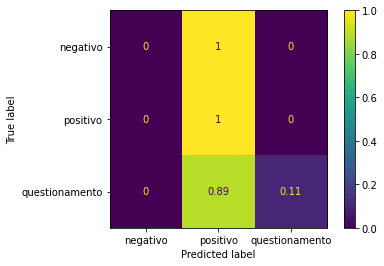

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                      values_format='.2g', normalize='true');

Pelo resultado apresentado acima, o f1_score para apenas os dados originais ficou em **0.58** e essa será o nosso score de corte para verificar o desempenho com os novos dados.

**2º passo - enriquecer a classe negativa com dados da base do Kaggle**

In [49]:
file_kaggle = 'dados_kaggle.csv'
df_kaggle = pd.read_csv(f'{url}/{file_kaggle}', sep=',')
df_kaggle = df_kaggle.drop(columns=['id', 'tweet_date', 'query_used'])
df_kaggle.columns = ['texto_reply', 'classificacao']
df_kaggle = df_kaggle.replace({'Negativo': 'negativo', 'Positivo': 'positivo'})

#limpando o texto original do twwet
df_kaggle['texto_reply'] = df_kaggle.apply(lambda row: _apply_all_steps(row['texto_reply']), axis=1)

df_kaggle.head()

,texto_reply,classificacao
0,vendo familia negative_emoticon fugidinha vera...,negativo
1,odeio fato provavelmente voto vai ter ir pro c...,negativo
2,"ciro "" mita "" tanto quanto outro , nao quero s...",negativo
3,raiva bolsonaro agora positive_emoticon,positivo
4,reflexos alienacao petista comandada lula pais...,negativo


In [50]:
df_minfra.classificacao.value_counts()

positivo          308
questionamento    112
negativo           44
Name: classificacao, dtype: int64

Precisaremos de pelo menos 350 tweets negativos na amostra do Kaggle, para complementar o dataset original.

In [51]:
#selecionando alguns tweets negativos para complementar os dados do minfra
sample_kaggle = df_kaggle.query('classificacao == "negativo"').sample(265, random_state=DEFAULT_RANDOM_STATE)

In [52]:
#juntando os dois datasets
new_df = pd.concat([df_minfra, sample_kaggle])

#embaralhando
new_df = new_df.sample(frac=1,
                       random_state=DEFAULT_RANDOM_STATE).reset_index(drop=True)

print('novo shape: ', new_df.shape)
new_df.head()

novo shape:  (729, 2)


,texto_reply,classificacao
0,sdd comunista negative_emoticon,negativo
1,"bom dia , ministro tarcisio enfim , chegou gra...",positivo
2,futuro presidente falta vice resolve,positivo
3,tomara obra feita encontro br trecho horrivel ...,questionamento
4,ciro negative_emoticon,negativo


In [53]:
new_df.classificacao.value_counts()

negativo          309
positivo          308
questionamento    112
Name: classificacao, dtype: int64

Agora que temos praticamente a mesma quantidade de tweets positivos e negativos no nosso dataset, vamos analisar de novo o f1_score.

In [54]:
y_pred = _train_and_check(new_df, X_test)

In [55]:
print('f1_score: ', f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, zero_division=0))

f1_score:  0.6166197142824148
                precision    recall  f1-score   support

      negativo       0.28      0.53      0.36        15
      positivo       0.78      0.95      0.86       102
questionamento       1.00      0.03      0.05        37

      accuracy                           0.69       154
     macro avg       0.69      0.50      0.42       154
  weighted avg       0.79      0.69      0.62       154



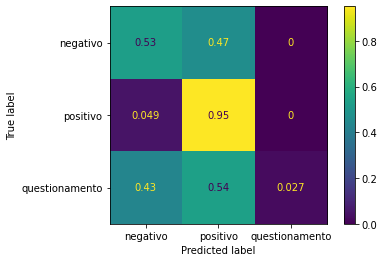

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                      values_format='.2g', normalize='true');

Percebe-se que agora o f1_score foi de **0.61**, um aumento considerável. Vamos novamente acrescentar mais dados e analisar o novo score.


**3º passo - enriquecer o dataset com mais dados classificados como questionamento**

In [57]:
#lendo arquivo com tweets classificados como questionamento
file = 'replies_classificadas_plus.csv'
df_plus = pd.read_csv(f'{url}/{file}', sep=',', index_col=0)
df_plus = df_plus[['texto_reply', 'classificacao']]
df_plus = df_plus.query('classificacao == "questionamento"')

#limpando o texto original do twwet
df_plus['texto_reply'] = df_plus.apply(lambda row: _apply_all_steps(row['texto_reply']), axis=1)

print('shape: ', df_plus.shape)
df_plus.head()

shape:  (43, 2)


,texto_reply,classificacao
0,duplicacao ministro ? alguma previsao ?,questionamento
2,alguma previsao vao comecar duplicacao br anap...,questionamento
12,comeca paulo ?,questionamento
23,"boa , trecho ecosul , polo pelotas br br r $ 1...",questionamento
29,ministro br319 ?,questionamento


In [58]:
#juntando os dois datasets
new_df_plus = pd.concat([new_df, df_plus])

#embaralhando
new_df_plus = new_df_plus.sample(frac=1,
                                 random_state = DEFAULT_RANDOM_STATE).reset_index(drop=True) 

print('novo shape: ', new_df_plus.shape)
new_df_plus.head()

novo shape:  (772, 2)


,texto_reply,classificacao
0,br montes claros entroncamento br 116 ?,questionamento
1,favor socorre trecho vitoria conquista ponte p...,questionamento
2,bom ministro semana curta acelerar obras sexta...,positivo
3,quero ver trecho rio santos comeca proximo gua...,questionamento
4,pior pensar povo elegeu negative_emoticon mete...,negativo


In [59]:
new_df_plus.classificacao.value_counts()

negativo          309
positivo          308
questionamento    155
Name: classificacao, dtype: int64

In [60]:
y_pred = _train_and_check(new_df_plus, X_test)

In [61]:
print('f1_score: ', f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, zero_division=0))

f1_score:  0.6691841745847079
                precision    recall  f1-score   support

      negativo       0.30      0.53      0.38        15
      positivo       0.80      0.95      0.87       102
questionamento       0.83      0.14      0.23        37

      accuracy                           0.71       154
     macro avg       0.64      0.54      0.49       154
  weighted avg       0.76      0.71      0.67       154



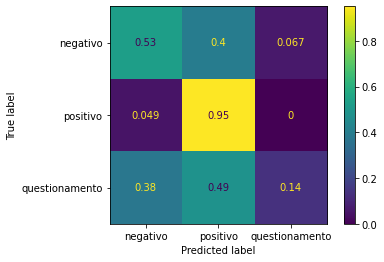

In [62]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                      values_format='.2g', normalize='true');

O novo f1_score ficou em **0.669**, um aumento de 0.05. Trabalharemos, de agora em diante, com essa configuração do dataset nos passos a seguir.

In [96]:
fig = go.Figure()
df_group = pd.DataFrame(new_df_plus.groupby('classificacao', as_index=False)['texto_reply'].count())
fig = px.bar(df_group, x="classificacao", y="texto_reply", text='texto_reply',
             color='classificacao')

fig.update_xaxes(categoryorder='total descending')
fig.update_layout(
    title_text = '<b>Distribuição da variável target</b><br />Após os ajustes para balanceamento',
    xaxis_title_text = 'Classificação',
    yaxis_title_text = 'Quantidade',
    template = 'plotly_white',
    autosize = False,
    width = 400,
    height = 400,
    showlegend=False
)

fig.show()

A nova configuração do dataset a ser utilizado agora possui praticamente a mesma quantidade de comentários 'positivos' (vermelho) e comentários 'negativos' (azuis). No entanto, a classe 'questionamento' continua com menos dados apesar do acréscimo de alguns. Por enquanto, não conseguiremos coletar e classificar mais tweets dessa classe por falta de tempo.

## 3 - Treinando e testando diversos modelos




In [66]:
print('Base de Teste - distribuição das classes')
df_teste.classificacao.value_counts()

Base de Teste - distribuição das classes


positivo          102
questionamento     37
negativo           15
Name: classificacao, dtype: int64

In [67]:
#montando o dataset para treino
df_treino = pd.concat([df_minfra, sample_kaggle, df_plus])

#embaralhando
df_treino = df_treino.sample(frac=1,
                             random_state=DEFAULT_RANDOM_STATE).reset_index(drop=True)

In [68]:
print('Base de Treino - distribuição das classes')
df_treino.classificacao.value_counts()

Base de Treino - distribuição das classes


negativo          309
positivo          308
questionamento    155
Name: classificacao, dtype: int64

In [69]:
print('Shape dos dados de teste: ', df_teste.shape)
print('Shape dos dados de treino: ', df_treino.shape)

Shape dos dados de teste:  (154, 2)
Shape dos dados de treino:  (772, 2)


Com os dados de treino e teste separados, iremos testar alguns modelos utilizando a validação cruzada, mas apenas com os dados de treino, já que os dados de teste serão utilizados apenas nas etapas de testes de hiperparâmetros e avaliação do modelo final.

**Testando diversos modelos**

In [70]:
X_train = df_treino['texto_reply']
y_train = df_treino['classificacao']

tfidf = TfidfVectorizer(tokenizer=_lemmatization, ngram_range = (1,2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [71]:
# conjunto de modelos a serem testados 
models = [
            DummyClassifier(strategy='most_frequent', random_state=DEFAULT_RANDOM_STATE),
            SGDClassifier(random_state=DEFAULT_RANDOM_STATE),
            SVC(random_state=DEFAULT_RANDOM_STATE),
            DecisionTreeClassifier(random_state=DEFAULT_RANDOM_STATE),
            RandomForestClassifier(random_state=DEFAULT_RANDOM_STATE),
            MultinomialNB(),
            XGBClassifier(random_state=DEFAULT_RANDOM_STATE)
          ]

# cria lista de score de cada modelo
models_scores = []

COLUNAS = ['Modelo', 'Média', 'Desvio']
dfScore = pd.DataFrame(columns=COLUNAS)

for model in models:
    val_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)
    nome_modelo = type(model).__name__ # somente para exibição do nome do modelo no output

    dfScore = dfScore.append({
            'Modelo': nome_modelo,
            'Média': np.mean(val_scores),
            'Desvio': np.std(val_scores)
        }, ignore_index=True)

# Mostra tabela com os scores dos modelos
Ranking = dfScore.sort_values(ascending= False, by = "Média")
Ranking 

,Modelo,Média,Desvio
1,SGDClassifier,0.874294,0.020655
6,XGBClassifier,0.869175,0.012543
4,RandomForestClassifier,0.853532,0.031488
3,DecisionTreeClassifier,0.838039,0.025552
2,SVC,0.810842,0.019338
5,MultinomialNB,0.790130,0.013073
0,DummyClassifier,0.400260,0.002381


In [72]:
fig = px.bar(dfScore, y='Modelo', color='Modelo', x='Média', orientation='h',
             text='Média')
fig.update_yaxes(categoryorder='total ascending')
fig.update_traces(texttemplate='%{text:.4f}', textposition='inside')
fig.update_layout(
    title_text = '<b>Ranking da acurária dos modelos testados</b>',
    xaxis_title_text = 'Média de Acurácia',
    yaxis_title_text = 'Modelo',
    template = 'plotly_white',
    autosize = False,
    width = 600,
    height = 400,
    showlegend=False
)
fig.show()

O modelo que obteve o melhor resultado foi o SGDClassifier. Vamos testar os hiperparâmetros para esse modelo a seguir.

## 4 - Testando os hiperparâmetros

Utilizaremos o GridSearch para testar a melhor combinação de hiperparâmetros.

**SGDClassifier**

[Documentação do Modelo](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [73]:
print('Hiperparâmetros padrões do SGDClassifier')
SGDClassifier().get_params()

Hiperparâmetros padrões do SGDClassifier


{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [74]:
model_sgd = SGDClassifier(random_state=DEFAULT_RANDOM_STATE)
param_grid = {
    "average": [True, False],
    "l1_ratio": [.0025, .0005, .001, .005, ],
    "alpha": np.power(10, np.arange(-4, 1, dtype=float)),
    'max_iter': [250, 500, 800],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'eta0': [.01]
}

grid_search = GridSearchCV(model_sgd, param_grid, n_jobs=-1, cv=5, )
grid_search.fit(X_train_tfidf, y_train)

print('Score SGDClassifier: ', grid_search.score(X_test_tfidf, y_test))
print(grid_search.best_estimator_)

Score SGDClassifier:  0.8116883116883117
SGDClassifier(eta0=0.01, l1_ratio=0.0025, max_iter=250, penalty='l1',
              random_state=42)


## 5 - Avaliando e interpretando os resultados

Com o melhor modelo e a sua melhor combinação de hiperparâmetros, vamos analisar o seu score.

### F1-score e Matriz de Confusão

acurácia:  0.9971264367816092
f1_score:  0.7885717320489205

                 precision    recall  f1-score   support

      negativo       0.33      0.09      0.14        11
      positivo       0.90      0.94      0.92        77
questionamento       0.64      0.75      0.69        28

      accuracy                           0.81       116
     macro avg       0.62      0.59      0.58       116
  weighted avg       0.78      0.81      0.79       116


Matriz de Confusão com os dados originais (desbalanceados)


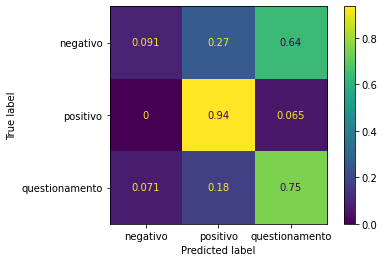

In [76]:
#DADOS ORIGINAIS (apenas para comparação)

X = df_minfra['texto_reply']
y = df_minfra['classificacao']

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.25,
                                                    random_state=DEFAULT_RANDOM_STATE,
                                                    stratify=y)

tfidf_orig = TfidfVectorizer(tokenizer=_lemmatization, ngram_range = (1,2))
X_train_tfidf_orig = tfidf_orig.fit_transform(X_train_orig)
X_test_tfidf_orig = tfidf_orig.transform(X_test_orig)

best_model_orig = SGDClassifier(random_state=DEFAULT_RANDOM_STATE)
best_model_orig.fit(X_train_tfidf_orig, y_train_orig)
y_pred_orig = best_model_orig.predict(X_test_tfidf_orig)

print('acurácia: ', best_model_orig.score(X_train_tfidf_orig, y_train_orig))
print('f1_score: ', f1_score(y_test_orig, y_pred_orig, average='weighted'))
print('\n', classification_report(y_test_orig, y_pred_orig, labels = best_model_orig.classes_))

print('\nMatriz de Confusão com os dados originais (desbalanceados)')
ConfusionMatrixDisplay.from_predictions(y_test_orig, y_pred_orig,
                                      values_format='.2g', normalize='true');

acurácia:  1.0
f1_score:  0.8054806828391734

                 precision    recall  f1-score   support

      negativo       0.47      0.47      0.47        15
      positivo       0.87      0.94      0.91       102
questionamento       0.76      0.59      0.67        37

      accuracy                           0.81       154
     macro avg       0.70      0.67      0.68       154
  weighted avg       0.81      0.81      0.81       154

Matriz de Confusão após balanceamento dos dados


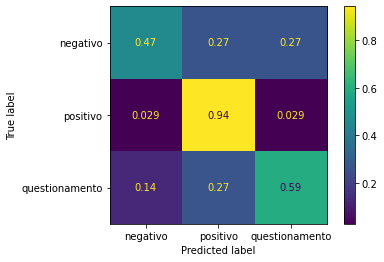

In [77]:
# instanciando o melhor modelo com os melhores hiperparâmetros
best_model = SGDClassifier(eta0=0.01, l1_ratio=0.0025, max_iter=250, penalty='l1',
              random_state=42)

best_model.fit(X_train_tfidf, y_train)
y_pred = best_model.predict(X_test_tfidf)

print('acurácia: ', best_model.score(X_train_tfidf, y_train))
print('f1_score: ', f1_score(y_test, y_pred, average='weighted'))
print('\n', classification_report(y_test, y_pred, labels = best_model.classes_))

print('Matriz de Confusão após balanceamento dos dados')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                      values_format='.2g', normalize='true');

O novo modelo agora possui **0.805** de f1_score e, comparando ambos os classification_report, percebemos que apesar da precisão de algumas classes ter piorado, conseguimos melhorar o recall das mesmas.

Analisando as duas matrizes de confusão (antes e depois), é possível verificar que houve uma melhora na predição certa de tweets negativos e de tweets com questionamento.

Vamos testar nosso modelo com novos dados para verificar a predição.

In [83]:
teste = ['Tarcisão da Galera, o homem das obras! Esse é bom de serviço! SELVA!!!',
         'A duplicação vai continuar até Miranda do Norte-MA?',
         'Br 316 castanhal até Santa Maria. Estrada da morte..nada nada e nada né ministro'
]

teste_limpo = [_apply_all_steps(txt) for txt in teste ]
teste_tfidf = tfidf.transform(teste_limpo)
pred = best_model.predict(teste_tfidf)

for i in range(len(pred)):
    print(teste_limpo[i], ' -> (', pred[i], ')')

tarcisao galera , homem obras ! bom servico ! selva !  -> ( positivo )
duplicacao vai continuar miranda norte ma ?  -> ( questionamento )
br castanhal santa maria estrada morte .. nada nada nada ne ministro  -> ( negativo )


### Medindo a importância das palavras


---



Nesta seção, queremos descobrir quais **recursos** se mostraram **mais relevantes** para o **modelo** encontrar a classe correta. Felizmente, nossa classe vencedora **SGDClassifier** nos permite encontrar facilmente essa informação através dos chamados **coeficientes** que nos fornece os **pesos atribuídos aos recursos.**

Lembrando que o nosso vocabulário possui **9.065** palavras.

Tecnicamente, os coeficientes são organizados em uma matriz à medida que cada classe compete entre si em um caminho um-para-um. Como temos **três classes** e as classes não precisam competir umas com as outras, existem 6 combinações possíveis, organizados conforme descrito na Tabela abaixo:
<br/><br/>



|                | Positivo | Negativo | Questionamento |
|----------------|:--------:|:--------:|:--------------:|
| Positivo       |     0    |     1    |        2       |
| Negativo       |          |     3    |        4       |
| Questionamento |          |         |        5       |


<center>Tabela 1 - Coeficientes para o classificador SGDClassifier </center> 




In [84]:
print(best_model.coef_)

[[-3.0307335  -0.79871724  0.         ...  0.          0.
   0.        ]
 [ 6.57214984  1.0824736   0.         ...  0.          0.
   0.        ]
 [-2.57940088  0.          0.         ...  0.          0.
   0.        ]]


As linhas devem ser lidas primeiro, então, se quisermos descobrir como o modelo **distingue Positivo de Negativo, devemos pegar o índice 0 dos coeficientes**. Na primeira etapa, classificamos os coeficientes por seus valores e mantemos os índices, que são as posições no vocabulário.

In [85]:
# coef_[0] yields a matrix
coef = best_model.coef_[1]
vocabulary_positions = coef.argsort()
vocabulary = tfidf.get_feature_names_out()

In [99]:
print(len(vocabulary))

9065


Posteriormente, pegamos as principais contribuições positivas e negativas:

In [86]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

Em seguida, vamos agregar isso a um DataFrame para tornar mais fácil a exibição dos resultados:

In [87]:
core_ui = pd.DataFrame([[vocabulary[c],
coef[c]] for c in top_positive_coef + top_negative_coef],
columns=["feature", "coefficient"]).sort_values("coefficient")

Gostaríamos de visualizar as contribuições dos coeficientes de cada palavra para facilitar a compreensão. Os **valores maiores que zero** (0) contrinuem para a **classe Positivo**, e os **valores inferiores a zero** para a **classe Negativo**, conforme Gráfico abaixo:


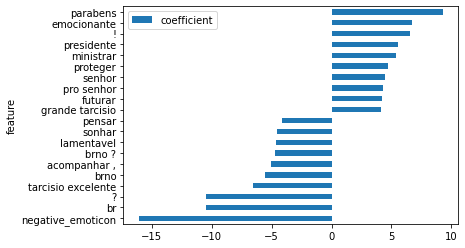

In [88]:
core_ui.set_index("feature").plot.barh();

Nesse formato, fica muito fácil interpretar os resultados obtidos pelo modelo SGDClassifier. Percebe-se que ele **aprendeu** muito bem que as **palavras emocionante, parabéns** e **presidente** são específicas dos **tweets Positivos**, enquanto **"lamentável", "emoji negativo", "br"**, são característicos de **tweets Negativos.**

Acabamos de encontrar os **recursos mais relevantes** para que o modelo SGDClassifier escolha entre Positivo e Negativo. Mas isso não indica quais recursos são importantes para identificar um tweet que pode ser categorizado como Negativo a partir de qualquer classe de comentário. 

Se quisermos obter esses recursos para a classe Negativo precisamos pegar os índices 1 e 2.

In [89]:
# coletando os coeficientes do modelo
c = best_model.coef_
coef = (c[1] + c[2])
vocabulary_positions = coef.argsort()

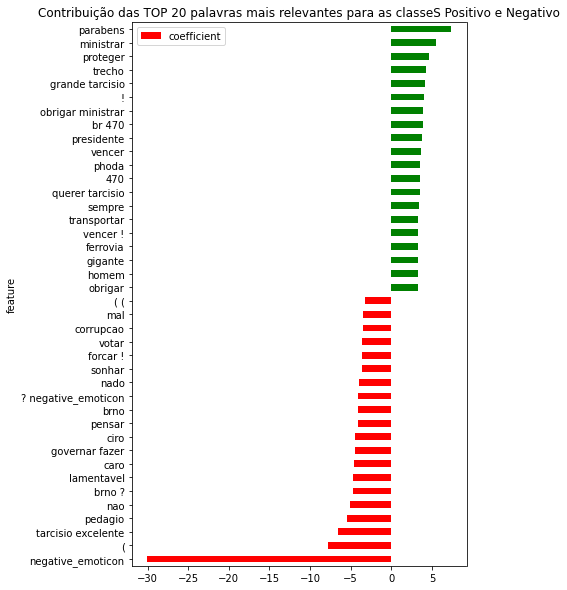

In [90]:
# coletando as principais contribuições positivas e negativas:
top_words = 20
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()
core = pd.DataFrame([[vocabulary[c], coef[c]]
                                    for c in top_positive_coef + top_negative_coef],
                                 columns=["feature", "coefficient"]).sort_values("coefficient")
core.set_index("feature").plot.barh(figsize=(6, 10),
                    color=[['red']*top_words + ['green']*top_words], title = "Contribuição das TOP 20 palavras mais relevantes para as classeS Positivo e Negativo");

### Biblioteca **ELI5**

**"Explique-me como se eu tivesse 5 anos":** usando ELI5 para explicar a classificação dos resultados


---

ELI5 é uma **biblioteca de software popular** para explicação do aprendizado de máquina usando o algoritmo LIME. 

As **características positivas** (ou seja, palavras) são mostradas **em verde**. Tons de verde mais intensos significa uma maior contribuição da palavra para a classe correspondente. 

As **cores vermelhas** funcionam exatamente o oposto: palavras que aparecem em vermelho **"repelem" as classes** (por exemplo, **"parabéns"** na parte inferior da primeira linha **rejeita fortemente** a **classe Negativo**). 

**BIAS** é um caso especial e contém a chamada interceptação, ou seja, **falhas sistemáticas do modelo**.

In [91]:
class_names = y_test.unique()
# a função show_weights retorna uma explicação dos parâmetros do modelo (pesos)
eli5.show_weights(best_model, top = 20, vec = tfidf, target_names = class_names)

**Exemplos de tweets e a influência de features nos mesmos**

In [92]:
print('Tweet: ', X_test.iloc[150], ' -> ', y_test.iloc[150], '\n')
eli5.show_prediction(best_model, X_test.iloc[150],target_names = class_names, vec = tfidf)

Tweet:  mp ferrovias ? vai deixar morrer 100bi investimento ?  ->  questionamento 



In [93]:
print('Tweet: ', X_test.iloc[88], ' -> ', y_test.iloc[88], '\n')
eli5.show_prediction(best_model, X_test.iloc[88],target_names = class_names, vec = tfidf)

Tweet:  parabens ministro thor ! senhor achado brasil !  ->  positivo 



In [94]:
print('Tweet: ', X_test.iloc[1], ' -> ', y_test.iloc[1], '\n')
eli5.show_prediction(best_model, X_test.iloc[1],target_names = class_names, vec = tfidf)

Tweet:  brs abandonadas enganador 70 votos nada investimentos estado  ->  negativo 



## 6 - Conclusão

Apesar do resultado alcançado ser considerado razoavél, há pontos a se melhorar tanto no processo de coleta e limpeza dos dados quanto no treinamento e avaliação do modelo.


**Pontos a melhorar**

*   A biblioteca utilizada no processo de lematização não funciona tão bem com palavras em português
*   Melhorar o processo de limpeza
*   Melhorar e padronizar o processo de coleta
    - foram perdidos os emojis durante a coleta?
    - houve moderação?
    - classificação enviesada por ter sido feita apenas por uma pessoa?
*   Nova coleta de tweets negativos e questionamento pela área de negócio
*   Utilizar um modelo pré-treinado, como o BERT, seria mais eficiente?
*   Utilizar técnicas de deep learning



